In [1]:
import numpy as np
import os
import pickle
import astropy
import corner
import matplotlib.pyplot as plt
import emcee
from math import isinf

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import selections
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals.utils import hd_orf
from enterprise.signals import utils
from enterprise_extensions.deterministic import cw_block_circ

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Optional mpi4py package is not installed.  MPI support is not available.


## Make PTA object

In [2]:
# load enterprise pulsar objects from pickle file
with open('ent_data_simulation/enterprise_pulsars.pkl', 'rb') as f:
    ent_psrs = pickle.load(f)

for psr in ent_psrs:
    print(psr.name)

J1312+0051
J1909-3744
J1455-3330
B1953+29
J0709+0458


In [3]:
print(dir(ent_psrs[0]))

['Mmat', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_decj', '_designmatrix', '_flags', '_get_pdist', '_get_planetssb', '_get_pos', '_get_radec', '_get_radec_from_ecliptic', '_get_ssb_lsec', '_get_sunssb', '_iisort', '_isort', '_pdist', '_planetssb', '_pos', '_pos_t', '_raj', '_residuals', '_set_dm', '_sort', '_ssbfreqs', '_stoas', '_sunssb', '_telescope', '_toaerrs', '_toas', 'backend_flags', 'dm', 'dmx', 'filter_data', 'fitpars', 'flags', 'freqs', 'iisort', 'isort', 'name', 'pdist', 'phi', 'planets', 'planetssb', 'pos', 'pos_t', 'residuals', 'set_flags', 'setpars', 'sort_data', 'stoas', 'sunssb', 'telescope', 'theta', 'to_pickle', 'toaerrs', 'toas']


In [124]:
psr = ent_psrs[0]
dir(psr)

['Mmat',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_decj',
 '_designmatrix',
 '_flags',
 '_get_pdist',
 '_get_planetssb',
 '_get_pos',
 '_get_radec',
 '_get_radec_from_ecliptic',
 '_get_ssb_lsec',
 '_get_sunssb',
 '_iisort',
 '_isort',
 '_pdist',
 '_planetssb',
 '_pos',
 '_pos_t',
 '_raj',
 '_residuals',
 '_set_dm',
 '_sort',
 '_ssbfreqs',
 '_stoas',
 '_sunssb',
 '_telescope',
 '_toaerrs',
 '_toas',
 'backend_flags',
 'dm',
 'dmx',
 'filter_data',
 'fitpars',
 'flags',
 'freqs',
 'iisort',
 'isort',
 'name',
 'pdist',
 'phi',
 'planets',
 'planetssb',
 'pos',
 'pos_t',
 'residuals',
 'set_flags',
 'setpars',
 'sort_data',
 'stoas',
 'sunssb',
 'telescope',
 'the

In [134]:
print(wrapped_psr._get_pos())
print(wrapped_psr.pos)

[-0.29600044  0.95123349  0.08682508]
[ 0.85338175  0.3815567  -0.35518175]


In [99]:
class WrappedPulsar:
    def __init__(self, pulsar):
        self._pulsar = pulsar
        self._custom_pos = None
        self._custom_toas = None
        self._custom_residuals = None

    @property
    def pos(self):
        return self._custom_pos if self._custom_pos is not None else self._pulsar.pos

    @pos.setter
    def pos(self, value):
        self._custom_pos = np.asarray(value)

    @property
    def pdist(self):
        return self._custom_pdist if self._custom_pdist is not None else self._pulsar.pdist

    @pdist.setter
    def pdist(self, value):
        self._custom_pdist = value

    @property
    def toas(self):
        return self._custom_toas if self._custom_toas is not None else self._pulsar.toas

    @toas.setter
    def toas(self, value):
        self._custom_toas = np.asarray(value)

    @property
    def stoas(self):
        return self._custom_stoas if self._custom_stoas is not None else self._pulsar.stoas

    @stoas.setter
    def stoas(self, value):
        self._custom_stoas = np.asarray(value)

    @property
    def toaerrs(self):
        return self._custom_toaerrs if self._custom_toaerrs is not None else self._pulsar.toaerrs

    @toaerrs.setter
    def toaerrs(self, value):
        self._custom_toaerrs = np.asarray(value)

    @property
    def residuals(self):
        return self._custom_residuals if self._custom_residuals is not None else self._pulsar.residuals

    @residuals.setter
    def residuals(self, value):
        self._custom_residuals = np.asarray(value)

    @property
    def Mmat(self):
        return self._custom_Mmat if self._custom_Mmat is not None else self._pulsar.Mmat

    @Mmat.setter
    def Mmat(self, value):
        self._custom_Mmat = np.asarray(value)

    # @property
    # def _residuals(self):
    #     return self._custom_residuals if self._custom_residuals is not None else self._pulsar._residuals

    # @property
    # def _toaerrs(self):
    #     return self._custom_toaerrs if self._custom_toaerrs is not None else self._pulsar._toaerrs

    # @property
    # def _stoas(self):
    #     return self._custom_stoas if self._custom_stoas is not None else self._pulsar._stoas

    def __getattr__(self, name):
        # delegate all other attributes/methods to the wrapped Pulsar object
        return getattr(self._pulsar, name)

In [112]:
with open('pta.pkl', 'rb') as f:
    pta_dict = pickle.load(f)

wrapped_psrs = []
for ii, psr in enumerate(ent_psrs):
    wrapped_psr = WrappedPulsar(psr)
    wrapped_psr.pos = wrapped_psr._pos = pta_dict['psr_pos'][ii]
    wrapped_psr.pdist = wrapped_psr._pdist = (pta_dict['psr_dists'][ii], 0.2)
    wrapped_psr.toas = wrapped_psr._toas = pta_dict['toas'][ii]
    wrapped_psr.stoas = wrapped_psr._stoas = pta_dict['toas'][ii]
    wrapped_psr.toaerrs = wrapped_psr._toaerrs = pta_dict['toaerrs'][ii]
    wrapped_psr.residuals = wrapped_psr._residuals = pta_dict['residuals'][ii]
    wrapped_psr.Mmat = wrapped_psr._Mmat = pta_dict['Mmats'][ii]
    wrapped_psrs.append(wrapped_psr)


In [113]:
# use built in backend selection
backend = selections.Selection(selections.by_backend)

# make white noise
wn = white_signals.MeasurementNoise(efac=parameter.Uniform(0.5, 3.0), 
                                    log10_t2equad=-1000, 
                                    selection=backend)

In [114]:
# make red noise model
logamp_min = -18.0
logamp_max = -11.0
gamma_min = 1.0
gamma_max = 7.0

# define red noise model parameters
logamp_param = parameter.Uniform(logamp_min, logamp_max)
gamma_param = parameter.Uniform(gamma_min, gamma_max)

# define powerlaw for GP prior
powlaw = gp_priors.powerlaw(log10_A=logamp_param, gamma=gamma_param)

# make red noise
# rn = gp_signals.FourierBasisGP(spectrum=powlaw, components=30)
rn = gp_signals.FourierBasisGP(spectrum=powlaw, components=10)

In [115]:
# make GWB
log10_A_gw = parameter.Uniform(logamp_min, logamp_max)('log10_A_gw')
gamma_gw = parameter.Uniform(gamma_min, gamma_max)('gamma_gw')
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
# gw = gp_signals.FourierBasisCommonGP(spectrum=cpl, orf=hd_orf(), components=30, name='gw')
gw = gp_signals.FourierBasisCommonGP(spectrum=cpl, orf=hd_orf(), components=10, name='gw')

In [116]:
# make CW signal
cw = cw_block_circ(dist_prior='log-uniform', psrTerm=True)

In [117]:
# make timing model
tm = gp_signals.TimingModel(use_svd=True)

In [118]:
# make model and PTA object
model = tm + wn
model += rn
model += gw
model += cw
pta = signal_base.PTA([model(psr) for psr in wrapped_psrs])

In [119]:
print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J1312+0051_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J1312+0051_measurement_noise             MeasurementNoise               1                   

params:
J1312+0051_efac:Uniform(pmin=0.5, pmax=3.0)                                               
__________________________________________________________________________________________
J1312+0051_red_noise                     FourierBasisGP                 2                   

params:
J1312+0051_red_noise_log10_A:Uniform(pmin=-18.0, pmax=-11.0)                              
J1312+0051_red_noise_gamma:Uniform(pmin=1.0, pmax=7.0)                                    
__________________________________________________________________________________________
J1312+0051_gw     

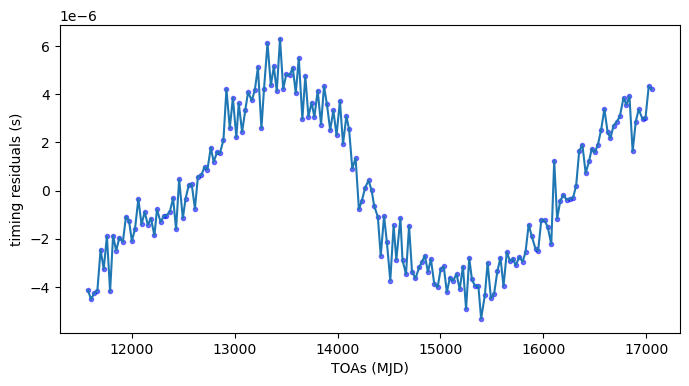

In [120]:
# plot timing residuals
psr_ndx = 0
plt.figure(figsize=(8, 4))
# plt.plot(ent_psrs[psr_ndx].toas/86400, ent_psrs[psr_ndx].residuals, 'b.', alpha=0.5)
plt.plot(wrapped_psrs[psr_ndx].toas/86400, wrapped_psrs[psr_ndx].residuals, 'b.', alpha=0.5)
plt.plot(pta_dict['toas'][psr_ndx] / 86400., pta_dict['residuals'][psr_ndx])
plt.xlabel('TOAs (MJD)')
plt.ylabel('timing residuals (s)');

In [121]:
for sc in pta._signalcollections:
    print(f"== {sc.psrname} ==")
    for s in sc._signals:
        if hasattr(s, "_ndiag"):
            for k, ndiag_fn in s._ndiag.items():
                ndiag_val = ndiag_fn(params={})
                print(f"  key: {k}, ndiag shape: {ndiag_val.shape}")
            if hasattr(s, "_masks"):
                for mask in s._masks:
                    print('mask!!!')
                    print(s._masks)
                    print(f"  mask shape: {mask.shape}")

== J1312+0051 ==
  key: , ndiag shape: (180,)
mask!!!
[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, 

In [122]:
wrapped_psr._toas.shape

(180,)

In [123]:
pta.get_ndiag({})

ValueError: operands could not be broadcast together with shapes (180,) (183,) 

## test Enterprise likelihood

In [40]:
# mapping between parameter list and dictionary

def get_dict(params):
    return {label: val for label, val in zip(pta.param_names, params)}

In [41]:
[print(name) for name in pta.param_names];

B1953+29_cw_p_dist
B1953+29_cw_p_phase
B1953+29_efac
B1953+29_red_noise_gamma
B1953+29_red_noise_log10_A
J0709+0458_cw_p_dist
J0709+0458_cw_p_phase
J0709+0458_efac
J0709+0458_red_noise_gamma
J0709+0458_red_noise_log10_A
J1312+0051_cw_p_dist
J1312+0051_cw_p_phase
J1312+0051_efac
J1312+0051_red_noise_gamma
J1312+0051_red_noise_log10_A
J1455-3330_cw_p_dist
J1455-3330_cw_p_phase
J1455-3330_efac
J1455-3330_red_noise_gamma
J1455-3330_red_noise_log10_A
J1909-3744_cw_p_dist
J1909-3744_cw_p_phase
J1909-3744_efac
J1909-3744_red_noise_gamma
J1909-3744_red_noise_log10_A
cw_cosinc
cw_costheta
cw_log10_Mc
cw_log10_dL
cw_log10_fgw
cw_phase0
cw_phi
cw_psi
gamma_gw
log10_A_gw


In [42]:
# store injected parameters and bounds on parameter space

x_inj = []
x_mins = []
x_maxs = []
for i in range(len(wrapped_psrs)):
    x_inj.append(ent_psrs[i].pdist[0])
    x_mins.append(0.1)
    x_maxs.append(7.0)
    x_inj.append(np.random.uniform(0, np.pi))
    x_mins.append(0.0)
    x_maxs.append(2. * np.pi)
    x_inj.append(4.33)
    x_mins.append(gamma_min)
    x_maxs.append(gamma_max)
    x_inj.append(-14.0)
    x_mins.append(logamp_min)
    x_maxs.append(logamp_max)
    x_inj.append(0.0)
    x_mins.append(-1.0)
    x_maxs.append(1.0)
    x_inj.append(0.0)
    x_mins.append(-1.0)
    x_maxs.append(1.0)
    x_inj.append(9.0)
    x_mins.append(7.)
    x_maxs.append(10.0)
    x_inj.append(1.0)
    x_mins.append(-1.)
    x_maxs.append(2.)
    x_inj.append(-8.0)
    x_mins.append(-10.)
    x_maxs.append(-7.)
    x_inj.append(0.0)
    x_mins.append(-np.pi / 2.)
    x_maxs.append(np.pi / 2.)
    x_inj.append(np.pi)
    x_mins.append(0.)
    x_maxs.append(2. * np.pi)
    x_inj.append(0.0)
    x_mins.append(-np.pi / 2.)
    x_maxs.append(np.pi / 2.)
    x_inj.append(4.33)
    x_mins.append(gamma_min)
    x_maxs.append(gamma_max)
    x_inj.append(-14.0)
    x_mins.append(logamp_min)
    x_maxs.append(logamp_max)
x_inj = np.array(x_inj)
x_mins = np.array(x_mins)
x_maxs = np.array(x_maxs)

In [43]:
# make likelihood function (keeping parameters in domain)
def get_lnlike(params):
    if np.logical_or(np.any(params < x_mins),
                     np.any(params > x_maxs)):
        return -np.inf
    else:
        return pta.get_lnlikelihood(get_dict(params))

In [44]:
# psr_dists_inj, psr_dist_stdev = np.load('data_simulation/data/psr_dists.npy')
def ln_prior_CW(psr_dists):
    return -np.sum(np.array([(dist - dist_inj)**2. / (2. * stdev**2.) 
                    for dist, dist_inj, stdev in zip(psr_dists, pta_dict['psr_dists'], np.ones(len(wrapped_psr)) * 0.2)]))

In [45]:
num_psrs = len(pta.pulsars)
def ln_prior(params):
    psr_dists = params[:4 * num_psrs][::4]
    return ln_prior_CW(psr_dists)

In [22]:
param_dict = {name: params.sample() for name, params in zip(pta.param_names, pta.params)}

In [23]:
dir(psr)

['Mmat',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_decj',
 '_designmatrix',
 '_flags',
 '_get_pdist',
 '_get_planetssb',
 '_get_pos',
 '_get_radec',
 '_get_radec_from_ecliptic',
 '_get_ssb_lsec',
 '_get_sunssb',
 '_iisort',
 '_isort',
 '_pdist',
 '_planetssb',
 '_pos',
 '_pos_t',
 '_raj',
 '_residuals',
 '_set_dm',
 '_sort',
 '_ssbfreqs',
 '_stoas',
 '_sunssb',
 '_telescope',
 '_toaerrs',
 '_toas',
 'backend_flags',
 'dm',
 'dmx',
 'filter_data',
 'fitpars',
 'flags',
 'freqs',
 'iisort',
 'isort',
 'name',
 'pdist',
 'phi',
 'planets',
 'planetssb',
 'pos',
 'pos_t',
 'residuals',
 'set_flags',
 'setpars',
 'sort_data',
 'stoas',
 'sunssb',
 'telescope',
 'the

In [25]:
print(psr.toaerrs.shape)
print(wrapped_psr.toaerrs.shape)

(183,)
(180,)


In [28]:
pta.get_ndiag({})[0].shape

ValueError: operands could not be broadcast together with shapes (180,) (183,) 

In [26]:
pta.get_TNr(param_dict)

ValueError: operands could not be broadcast together with shapes (180,) (183,) 

In [67]:
# plot cross section of the likelihood over one parameter
# other parameters fixed at injected values

param_index = -5
num_pts = 100
param_vals = np.linspace(x_mins[param_index], x_maxs[param_index], num_pts)
likelihood_vals = np.zeros(num_pts)
for i in range(num_pts):
    params = np.copy(x_inj)
    params[param_index] = param_vals[i]
    likelihood_vals[i] = get_lnlike(params)


plt.plot(param_vals, likelihood_vals, color='blue', alpha=0.5, label='ln(likelihood)')
plt.axvline(x_inj[param_index], color='red', alpha=0.7, label='injection', lw=4)
plt.axvline(param_vals[np.argmax(likelihood_vals)], color='green', alpha=0.7, label='maximum', lw=2)
plt.xlabel(pta.param_names[param_index])
plt.legend()
plt.show()

/opt/anaconda3/envs/PTA-x86/lib/python3.10/site-packages/enterprise_extensions/deterministic.py:296: RuntimeWarning: invalid value encountered in arccos
  gwtheta = np.arccos(cos_gwtheta)


ValueError: operands could not be broadcast together with shapes (180,) (183,) 

## MCMC

In [18]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

# set up the sampler:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = '../samples/enterprise_chains'

# sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
#                  outDir=outDir, resume=False)
sampler = ptmcmc(ndim, get_lnlike, ln_prior, cov, 
                 outDir=outDir, resume=False)

# sampler for N steps
N = int(4e6)  # normally, we would use 5e6 samples (this will save time)
# x0 = np.hstack([p.sample() for p in pta.params])
x0 = x_inj
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

# store chains in compressed binary format
print('Loading chains.')
chains = np.loadtxt('../samples/enterprise_chains/chain_1.txt', skiprows=int(0), usecols=(range(ndim + 1)))
np.save('../samples/enterprise_chains/chains.npy', chains)
if os.path.exists('../samples/enterprise_chains/chains.npy') and os.path.getsize('../samples/enterprise_chains/chains.npy') > 0:
    os.remove('../samples/enterprise_chains/chain_1.txt')
    print('Chain saved to .npy file.')
    print('Original .txt file deleted successfully.')
else:
    print('Error: .npy file not created correctly. Original .txt file was not deleted.')

Finished 0.25 percent in 28.393696 s Acceptance rate = 0.493557Adding DE jump with weight 50
Finished 100.00 percent in 5742.952346 s Acceptance rate = 0.247729
Run Complete
Loading chains.
Chain saved to .npy file.
Original .txt file deleted successfully.


## post-processing

In [19]:
# load chain samples
chains = np.load('../samples/enterprise_chains/chains.npy')
samples = chains[:,:-1]

# number of samples
num_samples = len(samples)

# load likelihood values
lnposts = chains[:,-1]

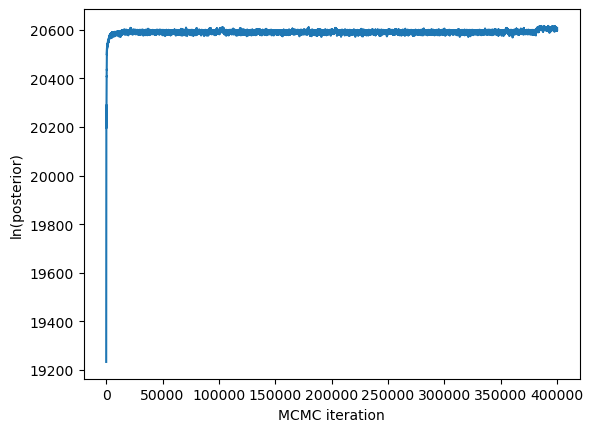

In [20]:
# plot likelihood of samples

plt.plot(lnposts)
plt.xlabel('MCMC iteration')
plt.ylabel('ln(posterior)')
plt.show()

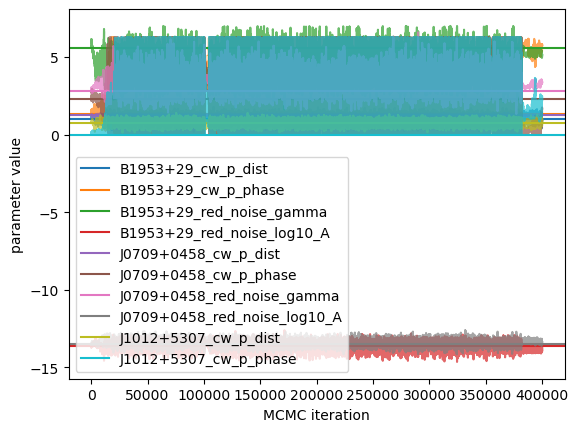

In [21]:
# make trace plot for parameters
for i in range(10):
    plt.plot(samples[:,i], color=f'C{i}', alpha=0.7)
    plt.axhline(x_inj[i], color=f'C{i}', label=pta.param_names[i])

plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend()
plt.show()

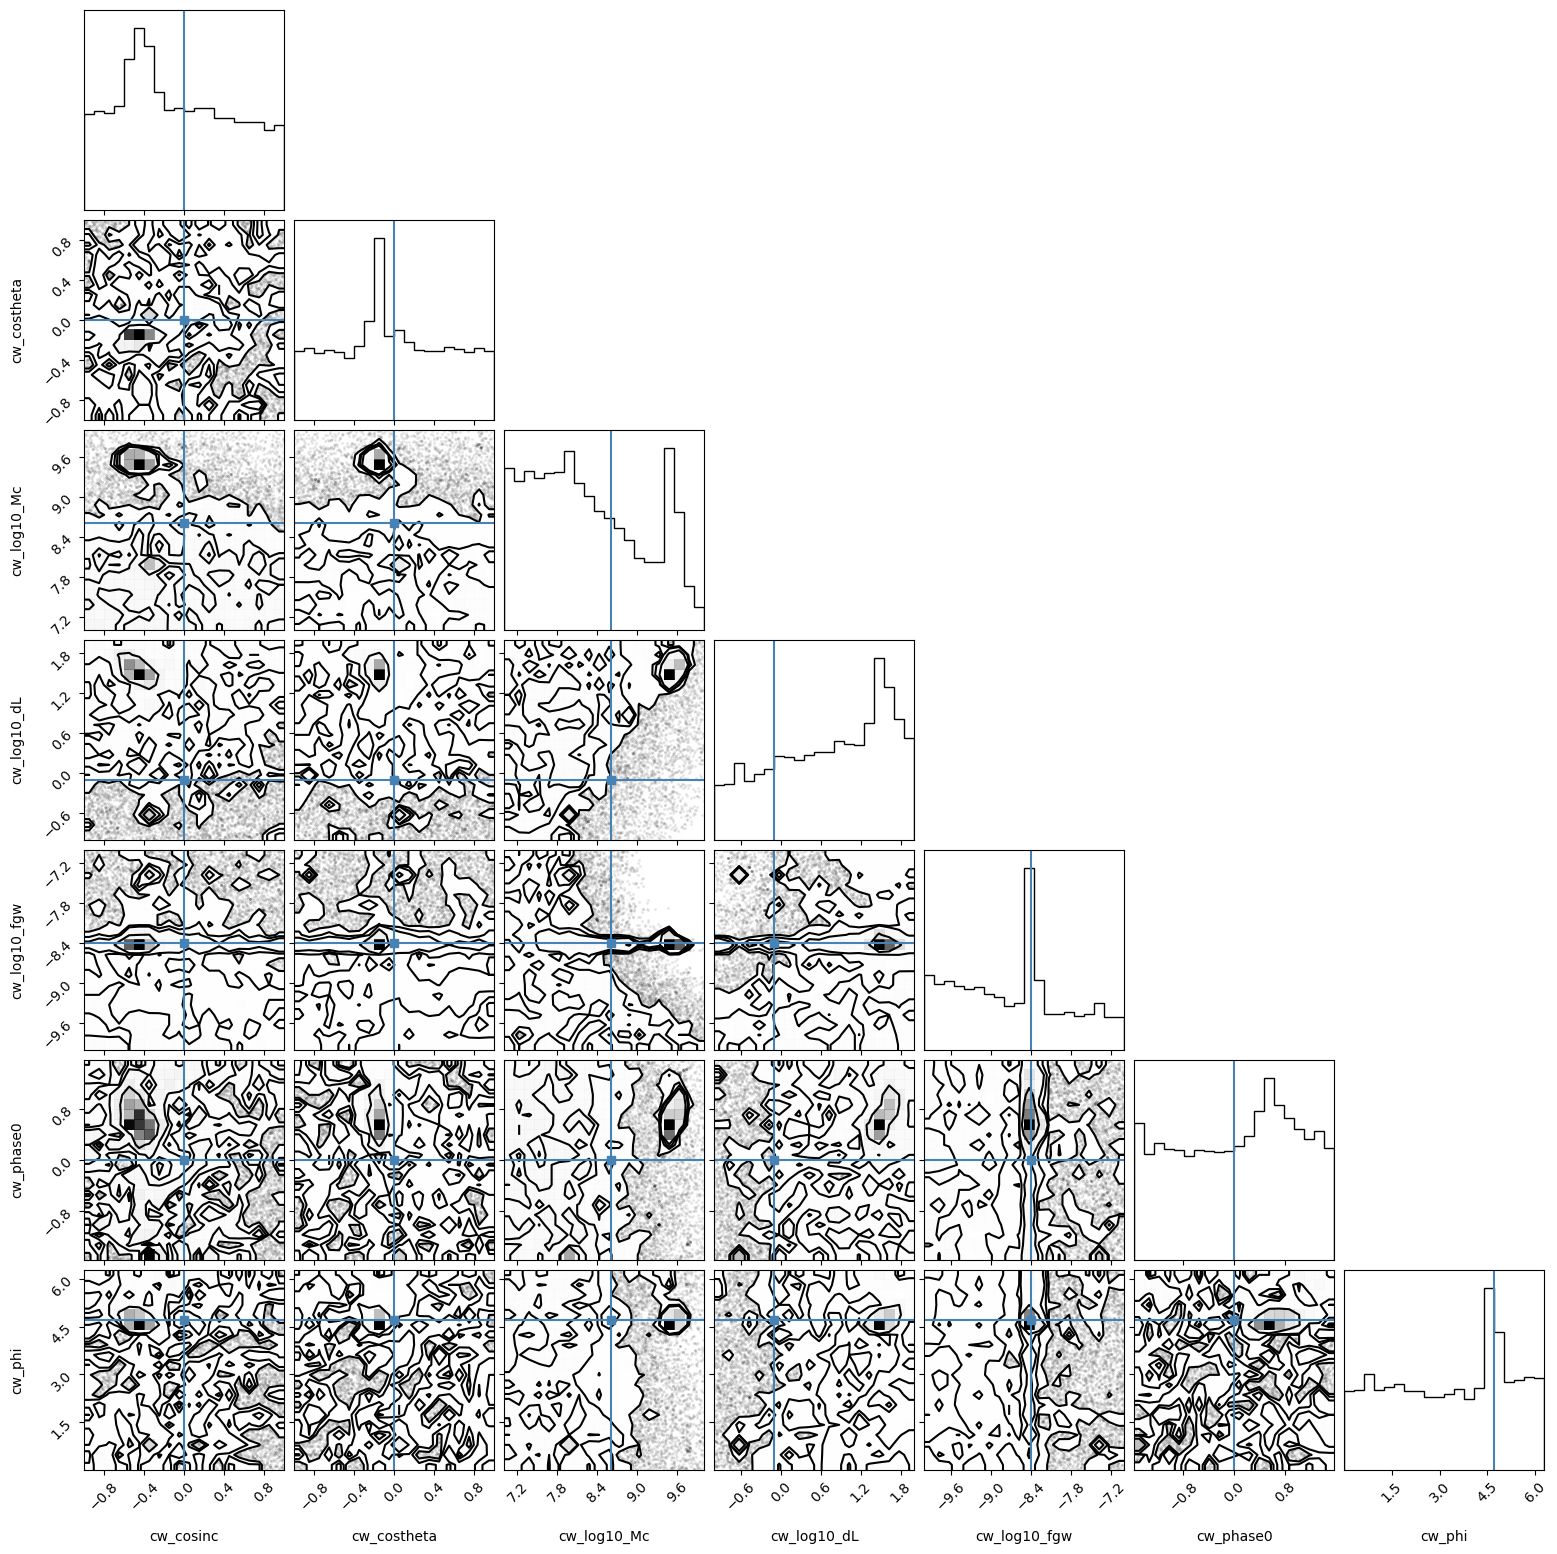

In [22]:
# make corner plot
# ndxs = np.r_[params_inj.num_psrs * 4:params_inj.num_psrs * 4 + 10]
ndxs = np.r_[-8:-1]
burnin = num_samples // 2
fig = corner.corner(samples[burnin::10, ndxs],
                    truths=x_inj[ndxs],
                    labels=np.array(pta.param_names)[ndxs])

In [23]:
# save thinned samples
np.save('../samples/enterprise_chains/ent_samples.npy', samples[burnin::10])
np.save('../samples/enterprise_chains/ent_lnposts.npy', lnposts[burnin::10])

In [24]:
# Assume samples is (n_samples, n_params) and post-burnin
effective_samples = samples[burnin::10]
tau = emcee.autocorr.integrated_time(effective_samples, quiet=True)
n_eff = effective_samples.shape[0] / np.max(tau)
print(tau)
print("Multivariate Effective Sample Size:", n_eff)

[27.39533029]
Multivariate Effective Sample Size: 730.0879305738305


In [25]:
[print(label) for label in pta.param_names];

B1953+29_cw_p_dist
B1953+29_cw_p_phase
B1953+29_red_noise_gamma
B1953+29_red_noise_log10_A
J0709+0458_cw_p_dist
J0709+0458_cw_p_phase
J0709+0458_red_noise_gamma
J0709+0458_red_noise_log10_A
J1012+5307_cw_p_dist
J1012+5307_cw_p_phase
J1012+5307_red_noise_gamma
J1012+5307_red_noise_log10_A
J1312+0051_cw_p_dist
J1312+0051_cw_p_phase
J1312+0051_red_noise_gamma
J1312+0051_red_noise_log10_A
J1453+1902_cw_p_dist
J1453+1902_cw_p_phase
J1453+1902_red_noise_gamma
J1453+1902_red_noise_log10_A
J1455-3330_cw_p_dist
J1455-3330_cw_p_phase
J1455-3330_red_noise_gamma
J1455-3330_red_noise_log10_A
J1640+2224_cw_p_dist
J1640+2224_cw_p_phase
J1640+2224_red_noise_gamma
J1640+2224_red_noise_log10_A
J1643-1224_cw_p_dist
J1643-1224_cw_p_phase
J1643-1224_red_noise_gamma
J1643-1224_red_noise_log10_A
J1705-1903_cw_p_dist
J1705-1903_cw_p_phase
J1705-1903_red_noise_gamma
J1705-1903_red_noise_log10_A
J1909-3744_cw_p_dist
J1909-3744_cw_p_phase
J1909-3744_red_noise_gamma
J1909-3744_red_noise_log10_A
cw_cosinc
cw_costh